# Antiderivative Operator - Aligned Dataset

This tutorial demonstrates the use of learning neural operators for a data driven use case (non-physics informed). 

### References
[1] [Antiderivative operator from an aligned dataset - DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

[2] [DeepONet Tutorial in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb)

### Install (Colab only)

In [8]:
#%pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
#%pip install watermark

### Imports

In [9]:
import os

from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import DataLoader
import time
from scipy.integrate import simpson, cumulative_trapezoid
from sklearn.model_selection import train_test_split
os.environ["DDE_BACKEND"] = "pytorch"
import deepxde as dde
# FIXME only for development
import sys
sys.path.insert(0, '../../src')

In [10]:
from neuromancer.callbacks import Callback
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules.blocks import MLP
from neuromancer.modules.activations import activations
from neuromancer.problem import Problem
from neuromancer.system import Node
from neuromancer.trainer import Trainer
from neuromancer.dynamics.operators import DeepONet

In [11]:
# PyTorch random seed
torch.manual_seed(1234)

# NumPy random seed
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Problem Setup

original source: [https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)  

We will learn the antiderivative operator 

$$G : v \mapsto u$$

defined by an ODE

$$\frac{du(x)}{dx} = v(x),\;\;x\in [0,1]$$

**Initial Condition:** 
$$u(0) = (0)$$

We learn *G* from a dataset. Each data point in the dataset is one pair of (v,u), generated as follows:

1. A random function *v* is sampled from a Gaussian random field (GRF) with the resolution m = 100.
2. Solve *u* for *v* numerically. We assume that for each *u*, we have the values of *u(x)* in the same N<sub>u</sub> = 100 locations. Because we have the values of *u(x)* in the same locations, we call this dataset as "aligned data".

* Dataset information
    * The training dataset has size 150.
    * The testing dataset has size 1000. (We split this into a dev/test split of size 500 each)
    * Input of the branch net: the functions *v*. It is a matrix of shape (dataset size, m), e.g., (150, 100) for the training dataset.
    * Input of the trunk net: the locations *x* of *u(x)*. It is a matrix of shape (*N<sub>u</sub>*, dimension)
        * i.e., (100,1) for both training and testing datasets.
    * Output: The values of *u(x)* in different locations for different *v*. It is a matrix of shape (dataset size, *N<sub>u</sub>*).
        * e.g., (150, 100) for the training dataset.



## Dataset Prep

In [12]:
t = 100
space = dde.data.GRF(N=t, length_scale=1)
features = space.random(size=50000)
h = 1/t
sensors = np.linspace(0, 1, num=t)[:, None]
y = space.eval_batch(features, sensors)
anti_y = []
print()
for yi in y:
    s0 = 0 # Initial Condition
    # Explicit Euler Method
    s = np.zeros(t)
    s[0] = s0
    for i in range(0, t - 1):
        s[i + 1] = s[i] + h*yi[i]
    #plt.figure()
    #plt.plot(sensors, yi, 'g', label="yi")
    # integrate
    anti_y.append(s)
    #plt.plot(sensors, s, 'b', label="integral yi")
    #plt.legend(loc='lower right')
anti_y = np.array(anti_y)
#plt.show()

In [13]:
def prepare_data(dataset, name):
    ## Note: transposing branch input because DictDataset in Neuromancer needs all tensors in the dict to have the same shape at index 0
    branch_inputs = dataset["X"][0].T
    trunk_inputs = dataset["X"][1]
    outputs = dataset["y"].T

    Nu = outputs.shape[0]
    Nsamples = outputs.shape[1]
    print(f'{name} dataset: Nu = {Nu}, Nsamples = {Nsamples}')

    # convert to pytorch tensors of float type
    t_branch_inputs = torch.from_numpy(branch_inputs).float()
    t_trunk_inputs = torch.from_numpy(trunk_inputs).float()
    t_outputs = torch.from_numpy(outputs).float()

    data = DictDataset({
        "branch_inputs": t_branch_inputs,
        "trunk_inputs": t_trunk_inputs,
        "outputs": t_outputs
    }, name=name)

    return data, Nu

### Create named dictionary datasets

In [14]:
# getting the shape of the generated data the same as the sample data
#branch_inputs = dataset_train["X"][0].T
#trunk_inputs = dataset_train["X"][1]
#outputs = dataset_train["y"].T
new_branch_inputs = y.T
new_trunk_inputs = sensors
new_outputs = anti_y.T
branch_inputs_train, branch_inputs_test, outputs_train, outputs_test = train_test_split(y, anti_y, test_size=0.8)
branch_inputs_dev, branch_inputs_test, outputs_dev, outputs_test = train_test_split(branch_inputs_test, outputs_test, test_size=0.5)
new_branch_inputs = branch_inputs_train.T
new_trunk_inputs = sensors
new_outputs = outputs_train.T

train_data = DictDataset({
    "branch_inputs": torch.from_numpy(branch_inputs_train.T).float(),
    "trunk_inputs": torch.from_numpy(new_trunk_inputs).float(),
    "outputs": torch.from_numpy(outputs_train.T).float()
}, name="train")
dev_data = DictDataset({
    "branch_inputs": torch.from_numpy(branch_inputs_dev.T).float(),
    "trunk_inputs": torch.from_numpy(new_trunk_inputs).float(),
    "outputs": torch.from_numpy(outputs_dev.T).float()
}, name="dev")
test_data = DictDataset({
    "branch_inputs": torch.from_numpy(branch_inputs_test.T).float(),
    "trunk_inputs": torch.from_numpy(new_trunk_inputs).float(),
    "outputs": torch.from_numpy(outputs_test.T).float()
}, name="test")
Nu = t
print()

### Create torch DataLoaders for the Trainer

In [15]:
batch_size = 100
print(f"batch_size: {batch_size}")
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = DataLoader(dev_data, batch_size=batch_size, collate_fn=dev_data.collate_fn, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=test_data.collate_fn, shuffle=False)

batch_size: 100


## Define node

In [16]:
in_size_branch = Nu
width_size = 40
depth_branch = 2
interact_size = 40
in_size_trunk = 1
depth_trunk = 2
branch_net = MLP(
    insize=in_size_branch,
    outsize=interact_size,
    nonlin=nn.ReLU,
    hsizes=[width_size] * depth_branch,
    bias=True,
)
trunk_net = MLP(
    insize=in_size_trunk,
    outsize=interact_size,
    nonlin=nn.ReLU,
    hsizes=[width_size] * depth_trunk,
    bias=True,
)
deeponet = DeepONet(
    branch_net=branch_net,
    trunk_net=trunk_net,
    bias=True
)

In [17]:
node_deeponet = Node(deeponet, ['branch_inputs', 'trunk_inputs'], ['g'], name="deeponet")
print(node_deeponet)

deeponet(branch_inputs, trunk_inputs) -> g


## Objective and Constraints in NeuroMANCER

We use Mean Squared Error(MSE) for our loss function

$$\sum_{i=1}^{D}(x_i-y_i)^2$$



In [18]:
var_y_est = variable("g")
var_y_true = variable("outputs")

nodes = [node_deeponet]

var_loss = (var_y_est == var_y_true.T)^2
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


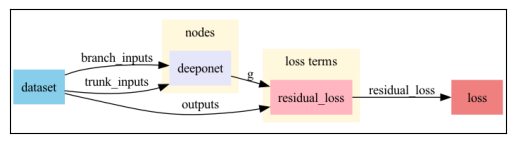

In [19]:
problem.show()

## Problem Solution in NeuroMANCER

In [20]:
lr = 0.001              # step size for gradient descent
epochs = 10000          # number of training epochs
epoch_verbose = 100     # print loss/display loss plot when this many epochs have occurred
warmup = 100            # number of epochs to wait before enacting early stopping policy
patience = 0            # number of epochs with no improvement in eval metric to allow before early stopping

### Construct Trainer and solve the problem

In [21]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

class LossHistoryCallback(Callback):
    def end_epoch(self, trainer, output):
        if trainer.current_epoch % trainer.epoch_verbose == 0:
            train_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["train"]]
            dev_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["dev"]]
            clear_output(wait=True)
            plt.semilogy(train_loss_history, label="Train loss")
            plt.semilogy(dev_loss_history, label="Dev loss")
            plt.xlabel("# Epochs")
            plt.legend()
            plt.show()

loss_history_callback = LossHistoryCallback()


# define trainer
trainer = Trainer(
    problem.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    test_data=test_loader,
    optimizer=optimizer,
    logger=None,
    callback=loss_history_callback,
    epochs=epochs,
    patience=patience,
    epoch_verbose=epoch_verbose,
    train_metric='train_loss',
    dev_metric='dev_loss',
    test_metric='test_loss',
    eval_metric="dev_loss",
    warmup = warmup,
    device=device
)

In [22]:
%%time
best_model = trainer.train()

Early stopping!!!
CPU times: user 18 s, sys: 18 s, total: 36 s
Wall time: 14 s


In [23]:
# load best trained model
best_outputs = trainer.test(best_model)
problem.load_state_dict(best_model)

<All keys matched successfully>

In [24]:
train_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["dev"]]
mean_test_loss = best_outputs['mean_test_loss'].detach().cpu().numpy()
print(mean_test_loss)
print(f"len(train_loss_history): {len(train_loss_history)}")
print(f"len(dev_loss_history): {len(dev_loss_history)}")

5.3870932e-05
len(train_loss_history): 547
len(dev_loss_history): 547


## Plot loss history w/ mean test loss

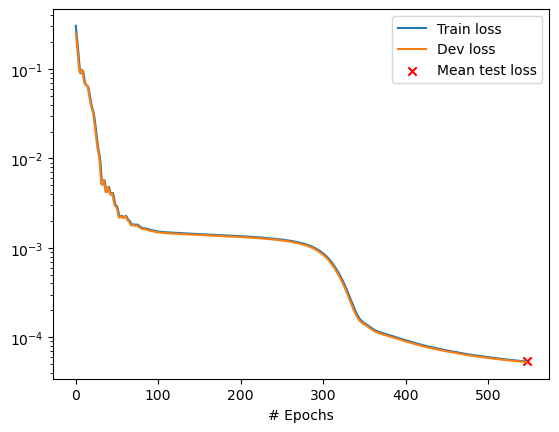

In [25]:
plt.semilogy(train_loss_history, label="Train loss")
plt.semilogy(dev_loss_history, label="Dev loss")
plt.scatter(len(train_loss_history), mean_test_loss, label="Mean test loss", c="red", marker='x')
plt.xlabel("# Epochs")
plt.legend()
plt.show()

## Compare results

torch.Size([100, 1]) torch.Size([100, 1])


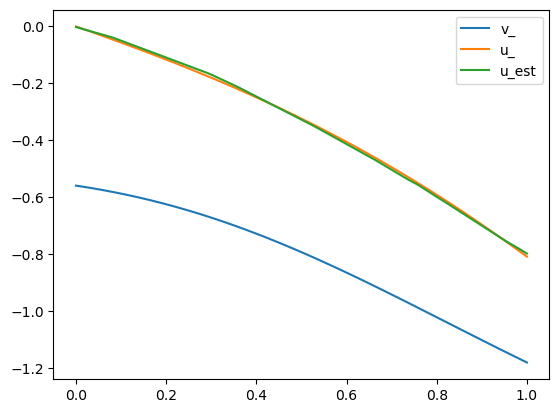

In [26]:
k = 18 # k is the k-th function among the 500 test functions
v_ = test_data.datadict["branch_inputs"][:,k].reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)
# KeyError 'outputs' in Variable in loss
#with torch.no_grad():
#    res = problem.forward({'branch_inputs':v_, 'trunk_inputs':x_})
res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='v_')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='u_')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='u_est')

plt.legend()


## Symbolic Integral Examples

torch.Size([100, 1]) torch.Size([100, 1])


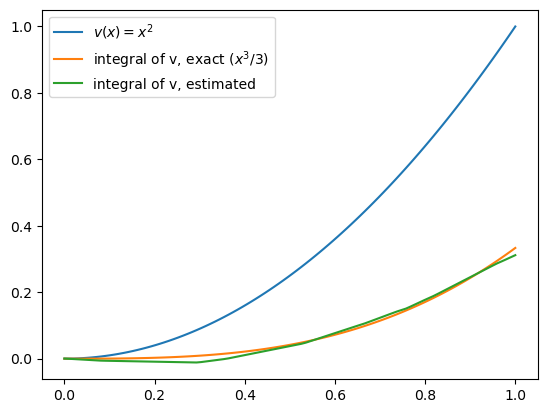

In [27]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

# KeyError 'outputs' in Variable in loss
#with torch.no_grad():
#with torch.no_grad():
#    res = problem.forward({'branch_inputs':v_, 'trunk_inputs':x_})
res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='integral of v, estimated')
plt.legend()


torch.Size([100, 1]) torch.Size([100, 1])


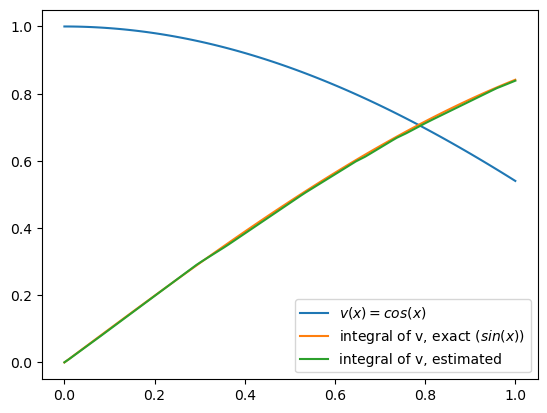

In [28]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.cos(x_).reshape(-1,1)

print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = torch.sin(x_).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='$v(x) = cos(x)$')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='integral of v, exact ($sin(x)$)')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='integral of v, estimated')
plt.legend()

### Watermark

In [29]:
%load_ext watermark
%watermark
%watermark --iversions

Last updated: 2024-08-28T16:45:44.750609-07:00

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.25.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

matplotlib: 3.8.4
torch     : 2.3.1
numpy     : 1.23.5
sys       : 3.10.14 (main, May  6 2024, 14:42:37) [Clang 14.0.6 ]
deepxde   : 1.11.2.dev1+g3810a98

